In [ ]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 9.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [ ]:
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from copy import deepcopy
import torch.nn as nn
import pytorch_lightning as pl
from sklearn.metrics import r2_score
from typing import Type, Dict
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.progress import RichProgressBar
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from pytorch_lightning import LightningModule

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data Statistics

In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

# Load the data
df = pd.read_csv('PATH_TO_LABELS')
df = df.drop(columns='Image Name')

In [ ]:
styled = df.describe().style.format("{:.2f}").set_table_attributes("border=1").set_caption("Descriptive Statistics")
display(styled)

,AREA_PX,PERIMETER_PX,ROUNDNESS,ROUNDNESS2,ISOTROPY,COMPACTNESS,ECCENTRICITY,RMS,SOL,[34;38;22],[90;98;58],[90;108;48],[106;113;48],[118;127;55],[128;139;60],[146;146;74],[162;163;72],[186;182;140],[190;162;130],[182;166;133],[170;144;104],[133;114;73],Lesion_segmentation,Lesion_mask
count,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00,2298.00
mean,25876.04,1565.98,0.14,0.91,0.66,0.58,0.18,0.48,15.58,974.46,1847.26,1334.55,8106.31,7055.52,1657.28,1304.74,40.28,66.43,42.84,288.90,993.51,2163.80,0.06,0.05
std,4952.71,196.82,0.06,0.02,0.12,0.11,0.05,0.13,4.83,119.78,2513.85,1626.75,4330.51,3270.58,1370.84,857.45,210.80,252.26,188.76,414.75,690.26,1025.30,0.07,0.08
min,10609.00,760.67,0.06,0.64,0.26,0.26,0.09,0.07,4.14,443.00,0.00,0.00,0.00,0.00,2.00,38.00,0.00,0.00,0.00,0.00,60.00,36.00,0.00,0.00
25%,22538.50,1431.48,0.10,0.90,0.57,0.50,0.15,0.39,12.01,898.00,341.25,208.00,4786.00,4656.25,586.50,666.00,0.00,1.00,0.00,99.00,574.25,1503.00,0.03,0.00
50%,25633.00,1597.31,0.12,0.91,0.66,0.58,0.17,0.48,15.21,972.00,894.00,716.00,8130.00,6879.00,1377.00,1177.00,0.00,8.00,0.00,195.00,827.00,1945.50,0.04,0.02
75%,29190.00,1701.53,0.17,0.92,0.75,0.66,0.20,0.56,18.62,1047.00,2214.50,1824.00,11335.25,9257.50,2318.00,1739.00,5.00,41.00,5.00,340.00,1209.75,2605.00,0.07,0.06
max,43413.00,2263.97,0.60,0.96,0.91,0.90,0.99,0.96,33.62,1436.00,19377.00,9909.00,20572.00,20334.00,10556.00,8039.00,3764.00,3734.00,2494.00,6798.00,6902.00,9943.00,0.77,0.70


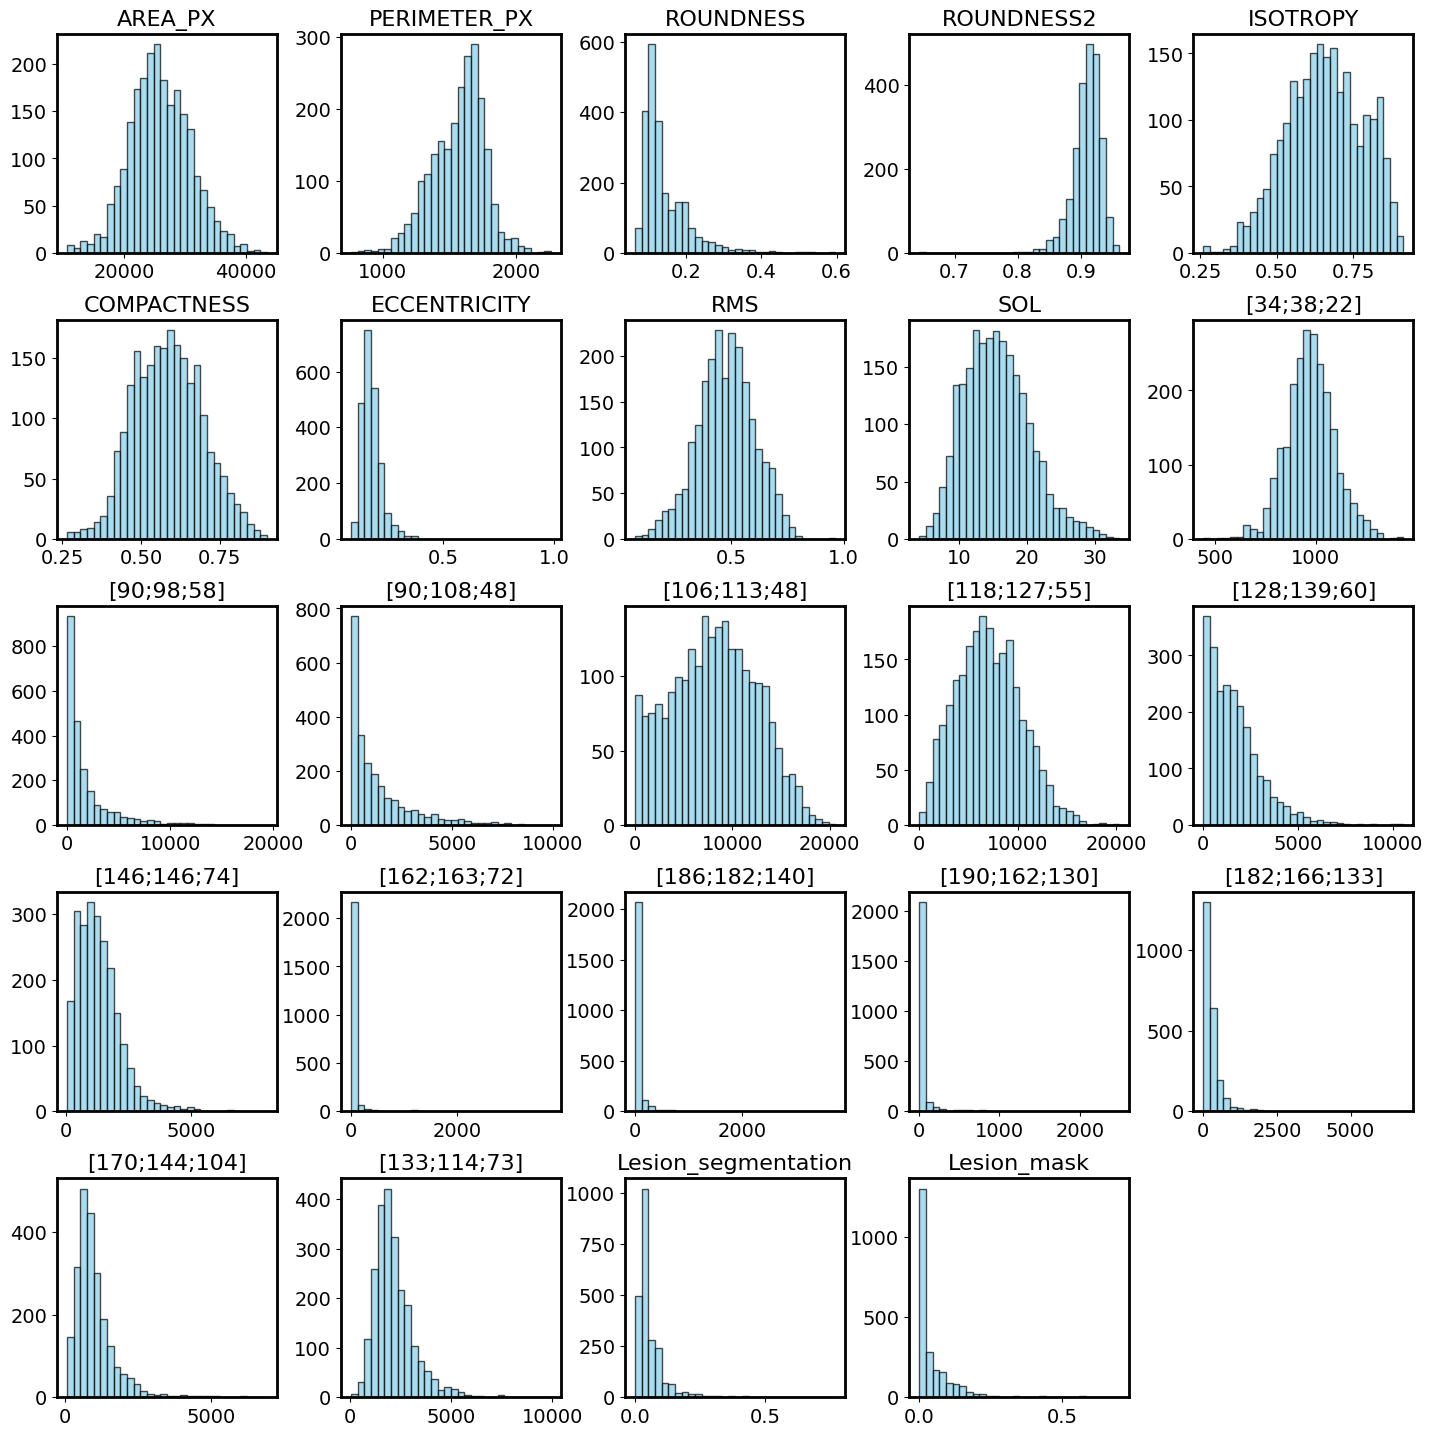

In [ ]:
num_cols = len(df.columns)
grid_cols = int(np.ceil(np.sqrt(num_cols)))
grid_rows = int(np.ceil(num_cols / grid_cols))
ax = df.hist(figsize=(15, 15), bins=30, color="skyblue", edgecolor="k", grid=False, layout=(grid_rows, grid_cols), alpha=0.7)


for axis in ax.ravel():
    if axis:
        axis.set_title(axis.get_title(), fontsize=16)

        axis.tick_params(axis='both', labelsize=14)

        for spine in axis.spines.values():
            spine.set_linewidth(2)

plt.tight_layout(pad=3.0, w_pad=-1.3, h_pad=1.0)
plt.show()

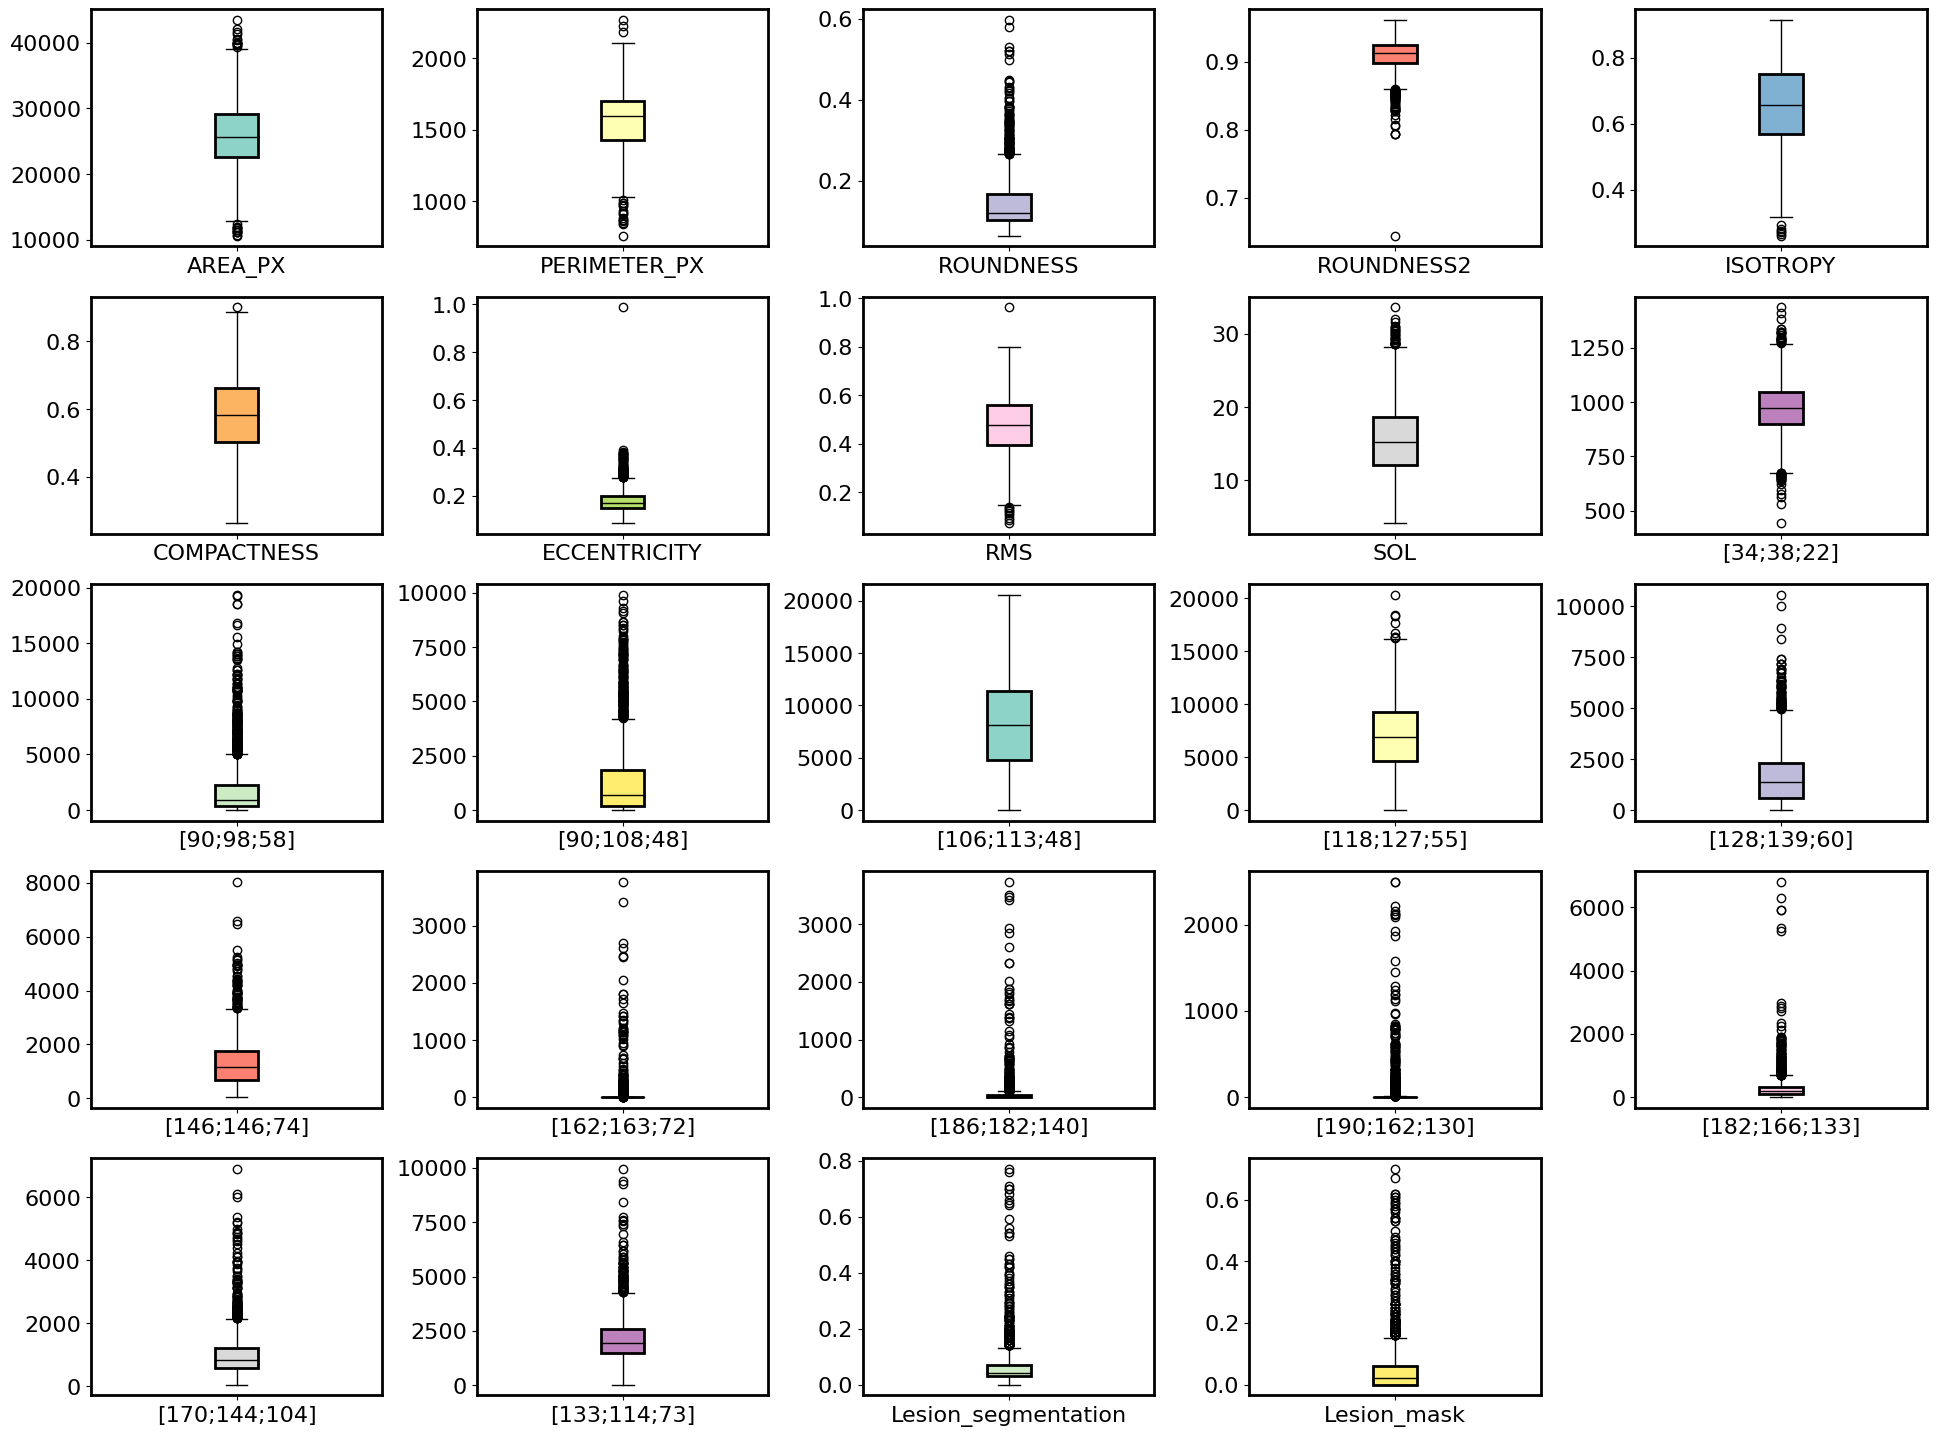

In [ ]:
colors = sns.color_palette("Set3", num_cols)

fig, axes = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=(20, 15))
flat_axes = axes.ravel()

for i, col in enumerate(df.columns):
    df[col].plot(kind='box', ax=flat_axes[i], patch_artist=True,
                 boxprops=dict(facecolor=colors[i], color='black', linewidth=2),
                 medianprops=dict(color='black'),
                 whiskerprops=dict(color='black'),
                 capprops=dict(color='black'))

    flat_axes[i].tick_params(axis='both', labelsize=16)
    flat_axes[i].set_xlabel('')
    for spine in flat_axes[i].spines.values():
        spine.set_linewidth(2)

for i in range(num_cols, grid_rows*grid_cols):
    fig.delaxes(flat_axes[i])

plt.tight_layout(pad=3.0, w_pad=1, h_pad=1.0)
plt.show()

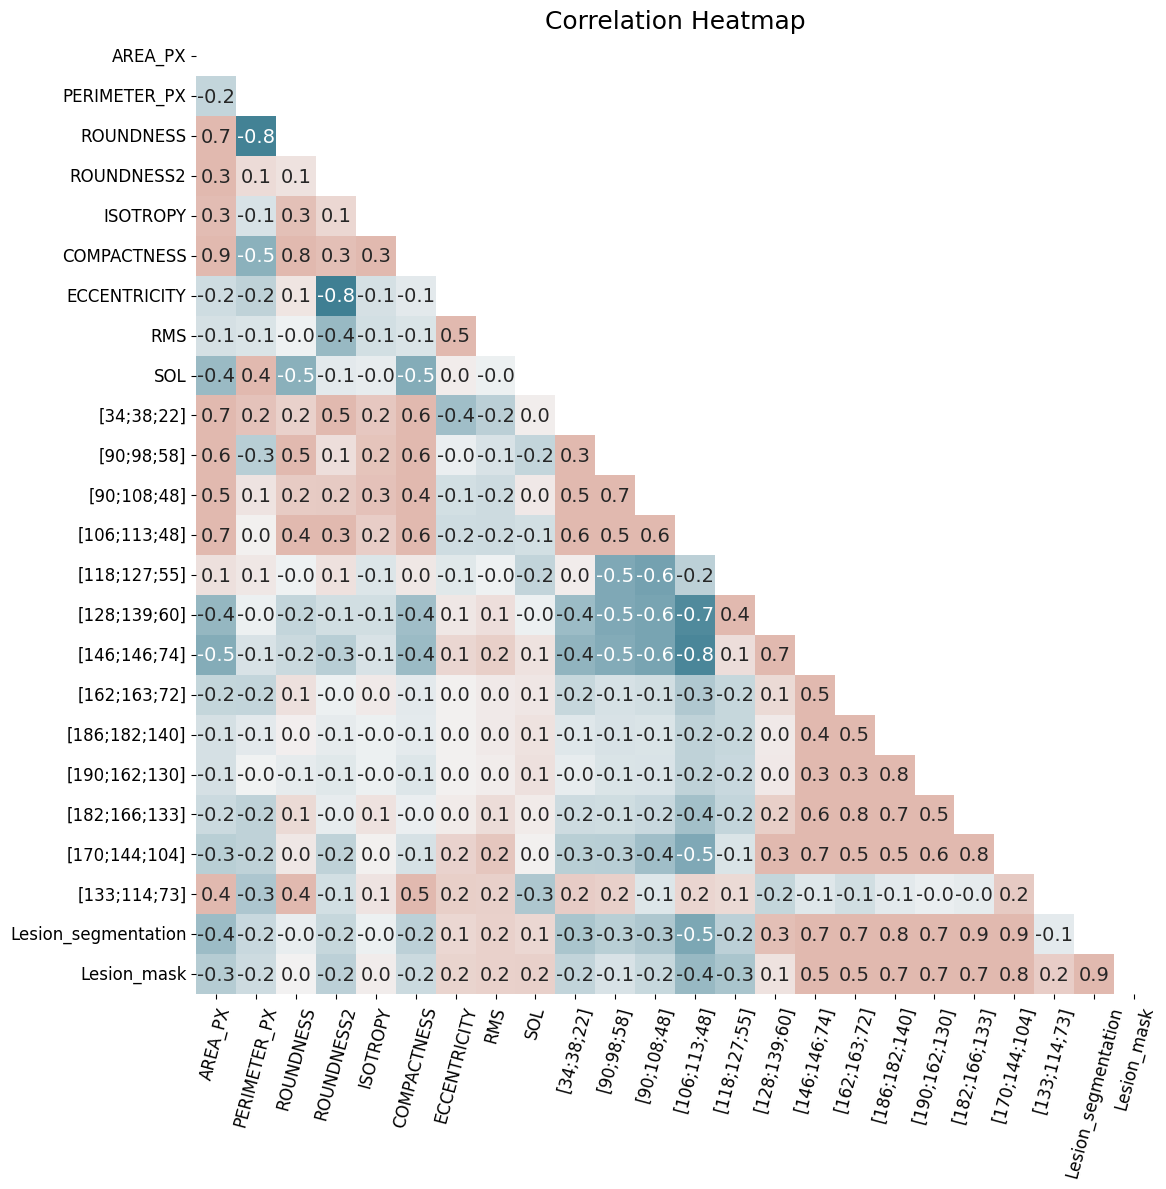

In [ ]:
corr = df.corr()

plt.figure(figsize=(15, 12))

cmap = sns.diverging_palette(220, 20, as_cmap=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            annot=True, fmt=".1f", annot_kws={'size': 14},
            square=True, linewidths=0, cbar=False)

plt.title('Correlation Heatmap', fontsize=18)
plt.xticks(fontsize=12, rotation=75)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

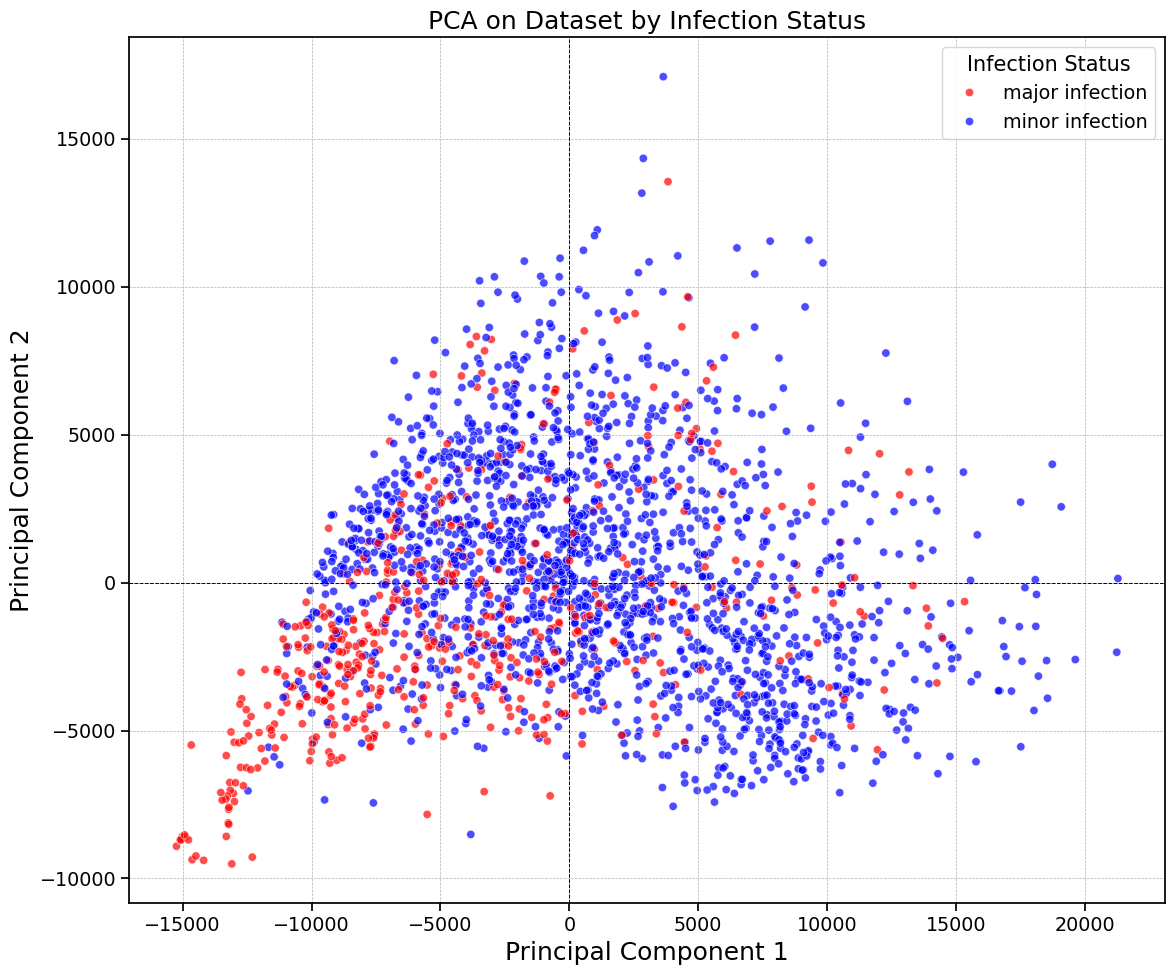

In [ ]:

df['Infection_Status'] = df['Lesion_mask'].apply(lambda x: 'minor infection' if x < 0.07 else 'major infection')

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df.drop(columns=['Infection_Status']))

sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})

plt.figure(figsize=(12, 10))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['Infection_Status'],
                palette={'minor infection': 'blue', 'major infection': 'red'},
                alpha=0.7, edgecolor="w", linewidth=0.5)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.7)
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.7)

plt.title('PCA on Dataset by Infection Status', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=18)
plt.ylabel('Principal Component 2', fontsize=18)

plt.legend(title='Infection Status')
plt.tight_layout()

plt.show()

In [ ]:
from scipy import stats
from scipy.stats import norm, lognorm, expon, gamma, beta, weibull_min

In [ ]:
def best_fit_distribution(data, bins=200):
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    DISTRIBUTIONS = [norm, lognorm, expon, gamma, beta, weibull_min]
    best_fit_name = ""
    best_fit_params = None
    best_sse = np.inf

    for distribution in DISTRIBUTIONS:
        try:
            with np.errstate(all='ignore'):
                params = distribution.fit(data)

                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                if best_sse > sse:
                    best_fit_name = distribution.name
                    best_fit_params = params
                    best_sse = sse

        except Exception as e:
            pass

    return best_fit_name

results = {}
for col in df.columns:
    results[col] = best_fit_distribution(df[col])

print("Best fitting distribution for each column:\n")
for col, dist_name in results.items():
    print(f"{col} -> {dist_name}")

Best fitting distribution for each column:

AREA_PX -> lognorm
PERIMETER_PX -> weibull_min
ROUNDNESS -> lognorm
ROUNDNESS2 -> beta
ISOTROPY -> beta
COMPACTNESS -> beta
ECCENTRICITY -> lognorm
RMS -> norm
SOL -> beta
[34;38;22] -> gamma
[90;98;58] -> lognorm
[90;108;48] -> beta
[106;113;48] -> beta
[118;127;55] -> weibull_min
[128;139;60] -> beta
[146;146;74] -> weibull_min
[162;163;72] -> weibull_min
[186;182;140] -> beta
[190;162;130] -> beta
[182;166;133] -> lognorm
[170;144;104] -> gamma
[133;114;73] -> lognorm
Lesion_segmentation -> beta
Lesion_mask -> beta


# Load data by Custom DataLoader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, excel_path, img_dir, transform=None, compute_stats=True):
        self.dataframe = pd.read_csv(excel_path)
        self.img_dir = img_dir
        self.transform = transform
        self.scalers = {}

        self.column_names = self.dataframe.columns.difference(['Image Name']).to_list()

        if compute_stats:
            for col in self.column_names:
                scaler = StandardScaler()
                self.dataframe[col] = scaler.fit_transform(self.dataframe[[col]])
                self.scalers[col] = scaler

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        img_name += '.png'
        image = Image.open(img_name).convert("RGB")
        image = image.resize((224, 224))

        labels = self.dataframe.iloc[idx, 1:].values.astype(float)

        if self.transform:
            image = self.transform(image)

        return image, torch.FloatTensor(labels)

    def standardize_new_data(self, new_data_df):
        for col in self.column_names:
            new_data_df[col] = self.scalers[col].transform(new_data_df[[col]])

    def inverse_transform(self, standardized_data):
        original_data = {}
        for col, value in standardized_data.items():
            if col in self.scalers:
                original_data[col] = self.scalers[col].inverse_transform([[value]])[0,0]
        return original_data

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

img_dir = 'PATH_TO_DATA'
excel_path = 'PATH_TO_LABELS'

# Create dataset
dataset = CustomDataset(excel_path=excel_path, img_dir=img_dir, transform=transform)

# Split data to train/val/test/data plus augment train data

### Showcase of the augmnetation where we augment the data and concat with the original dataset, althou this is a valid approach we reccomend using augmentation on the fly as we did during our training

In [ ]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

aug_transform = transforms.Compose([
    transforms.RandomRotation((-90, 90)),
    transforms.GaussianBlur(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAdjustSharpness(),
    transforms.adjust_brightness(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.ToTensor(),
])


augmented_train_dataset = deepcopy(train_dataset)
augmented_train_dataset.dataset = deepcopy(train_dataset.dataset)
augmented_train_dataset.dataset.transform = aug_transform

combined_train_dataset = ConcatDataset([train_dataset, augmented_train_dataset])

train_loader = DataLoader(combined_train_dataset, num_workers=8, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, num_workers=8, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, num_workers=8, batch_size=32, shuffle=False)

In [ ]:
print(f"Number of samples in train_loader: {len(train_loader.dataset)}")
print(f"Number of samples in val_loader: {len(val_loader.dataset)}")
print(f"Number of samples in test_loader: {len(test_loader.dataset)}")

Number of samples in train_loader: 3216
Number of samples in val_loader: 344
Number of samples in test_loader: 346


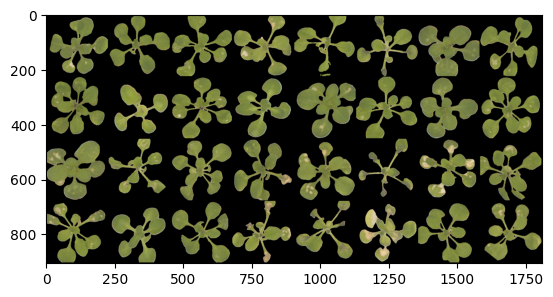

In [ ]:
import torchvision.utils as vutils
import numpy as np
images, labels = next(iter(train_loader))

grid = vutils.make_grid(images, normalize=True)

npimg = grid.numpy()

plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [ ]:
!pip install transformers
from transformers import AutoImageProcessor, ResNetForImageClassification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.9 MB/s eta 0:00:00


In [ ]:
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
num_outputs = 24
model.classifier[1] = nn.Linear(in_features=2048, out_features=num_outputs)

In [ ]:
class RegressionTask(LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = torch.nn.MSELoss()

    def forward(self, x):
        return self.model(x).logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, r2 = self._shared_eval_step(batch, batch_idx)
        self.log('val_loss', loss)
        self.log('val_r2', r2)
        return {'val_loss': loss, 'val_r2': r2}


    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        r2 = r2_score(y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())
        return loss, torch.tensor(r2, dtype=torch.float32)


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = {
            'scheduler': ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True),
            'monitor': 'val_loss',
        }
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor='val_loss', patience=25, verbose=True, mode='min')
        lr_monitor = LearningRateMonitor(logging_interval='epoch')
        model_checkpoint = ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min', verbose=True)
        rich_progress_bar = RichProgressBar()

        return [early_stop_callback, lr_monitor, model_checkpoint, rich_progress_bar]

In [ ]:
!rm -r lightning_logs/
!mkdir lightning_logs/

rm: cannot remove 'lightning_logs/': No such file or directory


In [ ]:
task = RegressionTask(model)

trainer = pl.Trainer(
    precision='32',
    gradient_clip_val=0.5,
    callbacks=task.configure_callbacks(),
    max_epochs=500
)

trainer.fit(task, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type                         ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model     │ ResNetForImageClassification │ 23.6 M │
│ 1 │ criterion │ MSELoss                      │      0 │
└───┴───────────┴──────────────────────────────┴────────┘

Trainable params: 23.6 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 23.6 M                                                                                               
Total estimated model params size (MB): 94

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.428
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 101: 'val_loss' reached 0.42847 (best 0.42847), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=101.ckpt' as top 1
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.418
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 202: 'val_loss' reached 0.41817 (best 0.41817), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=202.ckpt' as top 1


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, 
attempting graceful shutdown...

In [ ]:
torch.save(model.state_dict(), 'plant_predictor2.pt')
from google.colab import files

files.download('plant_predictor2.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
trainer.test(task, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.09249413013458252    │
│          test_r2          │    0.9135493636131287     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.09249413013458252, 'test_r2': 0.9135493636131287}]

In [ ]:
import random

def custom_test_loop(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)

            # Forward pass
            y_hat = model(x).logits

            # Compute the loss
            loss = criterion(y_hat, y)
            total_loss += loss.item()

            # Save labels and predictions for later analysis
            all_labels.append(y.cpu())
            all_predictions.append(y_hat.cpu())

    # Compute the average loss and R^2 score
    average_loss = total_loss / len(test_loader)
    all_labels = torch.cat(all_labels, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)
    r2 = r2_score(all_labels.numpy(), all_predictions.numpy())

    print("Average Loss:", average_loss)
    print("R^2 Score:", r2)

    # Print Original and Predicted Labels in different colors
    green_color = '\033[92m'
    blue_color = '\033[94m'
    reset_color = '\033[0m'

    # Randomly select 20 samples and round them
    num_samples = min(20, len(all_labels))
    selected_indices = random.sample(range(len(all_labels)), num_samples)

    for i in selected_indices:
        original_label = [round(num, 5) for num in all_labels[i].numpy()]
        predicted_label = [round(num, 5) for num in all_predictions[i].numpy()]
        print(f"{green_color}Original label{i + 1}:{reset_color} {original_label}\n{blue_color}Predicted label{i + 1}:{reset_color} {predicted_label}")

run1:
Average loss = 0.0401
R2 Score = 0.95